In [1]:
%pylab inline
import urllib
import seaborn as sns
import ipywidgets as widgets
sns.set_context('talk')

from skimage.measure import find_contours
from skimage.io import imread
from scipy.interpolate import interp1d
from scipy import fftpack

Populating the interactive namespace from numpy and matplotlib


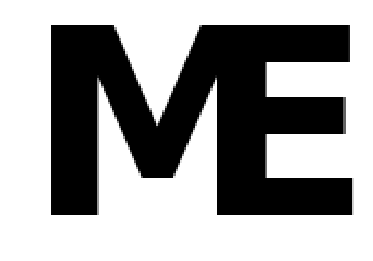

In [2]:
img = imread("https://raw.githubusercontent.com/ies-me/ME-Notebooks/master/ME.png")
imshow(img)
axis('off');

## Kontur als periodische Funktuon z(t)

In [3]:
contour = find_contours(img[:,:,0], .5)[0]
z_coef = contour[:,1] + (100-contour[:,0]) * 1j
z = interp1d(linspace(0,1,z_coef.shape[0]), z_coef)

In [4]:
@widgets.interact(t=(0,3,.001))
def plot_contour(t=0):
    plot(z_coef.real, z_coef.imag)
    x = z(t%1)
    plot(x.real, x.imag, 'o')
    text(x.real+3, x.imag-2, "t={:.3f}".format(t))
    sns.despine()
    show()

## FFT der Kontur

Abtastung an equidistanten Stützstellen $t_i = \frac{i}{501}, i = 0, \ldots, 500$

In [5]:
c_coef = fftpack.fftshift(fftpack.fft(z(linspace(0,1,501))))
n0 = 250

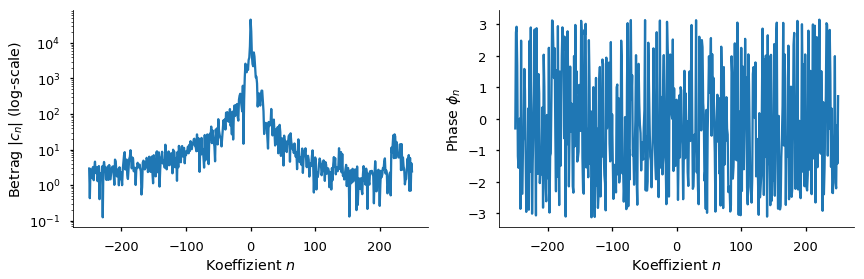

In [6]:
figure(figsize=(14,4))

subplot(121)
semilogy(arange(len(c_coef))-n0, abs(c_coef))
xlabel("Koeffizient $n$")
ylabel("Betrag $|c_n|$ (log-scale)")
sns.despine()

subplot(122)
plot(arange(len(c_coef))-n0, np.angle(c_coef))
xlabel("Koeffizient $n$")
ylabel("Phase $\\phi_n$")
sns.despine()

# Rekonstruktion

... ohne Beachtung der Skalierung aus den Koeffizienten $c_{-N}, \ldots, c_{-s}, c_s, \ldots c_N$:

$$z'(t) = \sum_{n=-N}^N \delta_{\left[|n| \ge s\right]}c_n \exp(2\pi{}j\cdot nt) \quad t \in [0,1)$$

In [7]:
def reconstruct_z(t, coef=c_coef):
    n0 = coef.shape[0]//2
    return sum(c * exp(2j*pi * (n-n0)*t) for n,c in enumerate(coef))

In [8]:
@widgets.interact(N=(1,100),s=(0,50))
def approx_contour(N=100,s=0):
    if s >= N: return
    cc = c_coef[n0-N:n0+N+1].copy()
    cc[N-s:N+s] = 0
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    axhline(0, color="gray", lw=1)
    axvline(0, color="gray", lw=1)
    plot(zz.real, zz.imag)
    sns.despine()
    if s > 0:
        title("Rekonstruktion aus $c_{{-{0}}}, \\ldots, c_{{-{1}}}, c_{{{1}}}, \\ldots, c_{{{0}}}$".format(N, s))
    else:
        title("Rekonstruktion aus $c_{{-{0}}}, \\ldots, c_{{{0}}}$".format(N))
    show()

## Zufällige Phase

Rekonstruktion mit $N = 42, s = 0$ und einer Komponente mit zufälliger Phase, $c_i \leftarrow |c_i| \exp(\varphi'\,2\pi\,j)\quad\text{mit }\varphi' \in [0,2\pi]$

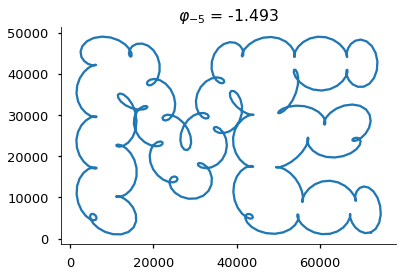

In [9]:
cc = c_coef[n0-42:n0+42].copy()
i = randint(len(cc))-42
cc[i] = abs(cc[42+i]) * exp(rand()*2j*pi)
title(r"$\varphi_{{{}}}$ = {:.3f}".format(i, np.angle(cc[i])))
zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
plot(zz.real, zz.imag)
sns.despine()

## Translationsinvarianz

Rekonstruktion mit $N = 23, s = 0$ und Normalisierung $c_0 \leftarrow 0$

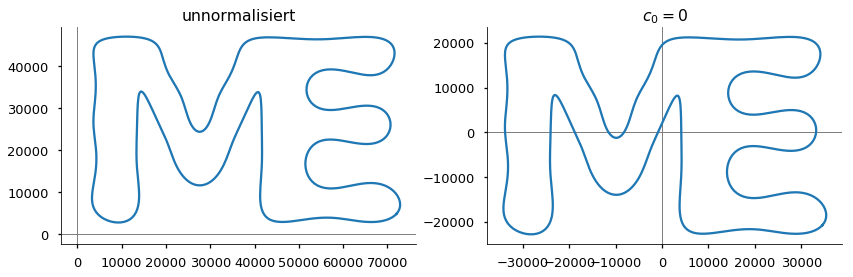

In [10]:
cc = c_coef[n0-23:n0+23].copy()

figure(figsize=(14,4))
subplot(121)
title(r"unnormalisiert")
axhline(0, color="gray", lw=1)
axvline(0, color="gray", lw=1)
zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
plot(zz.real, zz.imag)
sns.despine()

subplot(122)
title(r"$c_0 = 0$")
axhline(0, color="gray", lw=1)
axvline(0, color="gray", lw=1)
cc[len(cc)//2] = 0
zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
plot(zz.real, zz.imag)
sns.despine()

show()

## Skalierungsinvarianz

Rekonstruktion mit $N = 23, s = 0$ und Normalisierung

$$c_n \leftarrow \frac{c_n}{c_m}\quad \text{für festes }m\text{ und alle }-N \le n \le N$$

(Skala der Plots beachten!)

In [11]:
@widgets.interact(Skalierungsfaktor=(-5,5,.01), m=(-23,23))
def approx_contour(Skalierungsfaktor=1, m=1):
    zz = Skalierungsfaktor * z(linspace(0,1,501))
    cc = fftpack.fftshift(fftpack.fft(zz))
    cc = cc[n0-23:n0+23]
    
    figure(figsize=(14,4))
    subplot(121)
    title(r"unnormalisiert")
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    plot(zz.real, zz.imag)
    sns.despine()
    
    subplot(122)
    title(r"$c_n = c_n / |c_{{{}}}|$".format(m))
    cc /= abs(cc[m])
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    plot(zz.real, zz.imag)
    sns.despine()
    show()

## Rotationsinvarianz

Rekonstruktion mit $N = 23, s = 0$ und Normalisierung

$$c_n \leftarrow c_n \exp(-j \varphi_m)\quad \text{für festes } m$$

In [12]:
@widgets.interact(Drehwinkel=(-3.14,3.14,.01), m=(-23,23))
def approx_contour(Drehwinkel=0, m=16):
    zz = z(linspace(0,1,501)) * exp(Drehwinkel*1j)
    cc = fftpack.fftshift(fftpack.fft(zz))
    cc = cc[n0-23:n0+23]
    
    figure(figsize=(14,4))
    subplot(121)
    title(r"unnormalisiert")
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    plot(zz.real, zz.imag)
    sns.despine()
    
    subplot(122)
    title(r"$c_n = c_n \cdot \exp(-j\,\varphi_{{{}}})$".format(m))

    cc *= exp(-1j * np.angle(cc[m]))
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    plot(zz.real, zz.imag)
    sns.despine()
    show()